In [1]:
%load_ext autoreload
%autoreload 2 
%load_ext tensorboard

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import binary_cross_entropy_with_logits
import urllib.request
import os
import tarfile
import random
from icecream import ic

device = "mps" if torch.backends.mps.is_available() else "cpu"

# Cora dataset

https://graphsandnetworks.com/the-cora-dataset/

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

Load cora:

- D_inv is $D_{v,v}=Deg(v) = |N(v)|$, Deg is the nb of neighbours that each node has.
- adj_bar will be reused in $H^{(k+1)}=D^{-1}AH^{(k)}$. We will multiply by H at each layer.
- x: the features (words within doc)

In [4]:
# Load Cora dataset

# Download and extract if not present
if not os.path.exists("cora"):
    print("Downloading Cora dataset...")
    urllib.request.urlretrieve(
        "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz", "cora.tgz"
    )
    with tarfile.open("cora.tgz", "r:gz") as tar:
        tar.extractall()

# Load node features and labels
content_path = "cora/cora.content"
content = np.genfromtxt(content_path, dtype=str)
node_ids = content[:, 0].astype(int)
features = content[:, 1:-1].astype(np.float32)
class_strs = content[:, -1]

N = len(node_ids)
node_map = {node_id: i for i, node_id in enumerate(node_ids)}

# Features matrix
X = features  # Already in shape (N, 1433)

# Labels: 7 classes
class_map = {
    "Case_Based": 0,
    "Genetic_Algorithms": 1,
    "Neural_Networks": 2,
    "Probabilistic_Methods": 3,
    "Reinforcement_Learning": 4,
    "Rule_Learning": 5,
    "Theory": 6,
}
labels = np.array([class_map[c] for c in class_strs])

# Load edges (directed citations)
cites_path = "cora/cora.cites"
cites = np.genfromtxt(cites_path, dtype=int)
edges = []
for src, dst in cites:
    if src in node_map and dst in node_map:  # Ensure both exist
        src_idx = node_map[src]
        dst_idx = node_map[dst]
        edges.append([src_idx, dst_idx])

# Adjacency matrix (undirected, no self-loops)
A = np.zeros((N, N), dtype=np.float32)
for u, v in edges:
    A[u, v] = 1.0
    A[v, u] = 1.0  # Make undirected

# see page 50 of 03-GNN1.pdf
#
degrees = np.sum(A, axis=1)
degrees[degrees == 0] = 1.0  # Avoid division by zero
D_inv = np.diag(1.0 / degrees)
adj_bar = D_inv @ A
adj_bar = torch.FloatTensor(adj_bar)
# adj_bar will be used in $$D^{-1}AH^{(k)}$$

x = torch.FloatTensor(X)
pos_edges = np.array(edges)  # Directed for positive samples

# return x, adj_bar, pos_edges, labels, N


# x, adj_bar, pos_edges, labels, N = load_cora()
ic(x.shape, adj_bar.shape, pos_edges.shape, labels.shape, degrees.shape, N, set(labels))
features_nb = x.shape[1]
ic(features_nb);

ic| x.shape: torch.Size([2708, 1433])
    adj_bar.shape: torch.Size([2708, 2708| x.shape: torch.Size([2708, 1433])
    adj_bar.shape: torch.Size([2708, 2708])
    pos_edges.shape: (5429, 2)
    labels.shape: (2708,)
    degrees.shape])
    pos_edges.shape: (5429, 2)
    labels.shape: (2708,)
    degrees.shape: (2708,)
    N: 2708
    set(labels): {0, 1, 2, 3, 4, 5, 6: (2708,)
    N: 2708
    set(labels): {0, 1, 2, 3, 4, 5, 6}
ic| features_nb: 1433
}
ic| features_nb: 1433


Visualizing subgraph with 1640 high-degree nodes (degree >= 3)
Subgraph has 1640 nodes and 3849 edges


/var/folders/p4/b3p9tbn949714k6ymvrnpslm0000gq/T/ipykernel_92107/1692751075.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


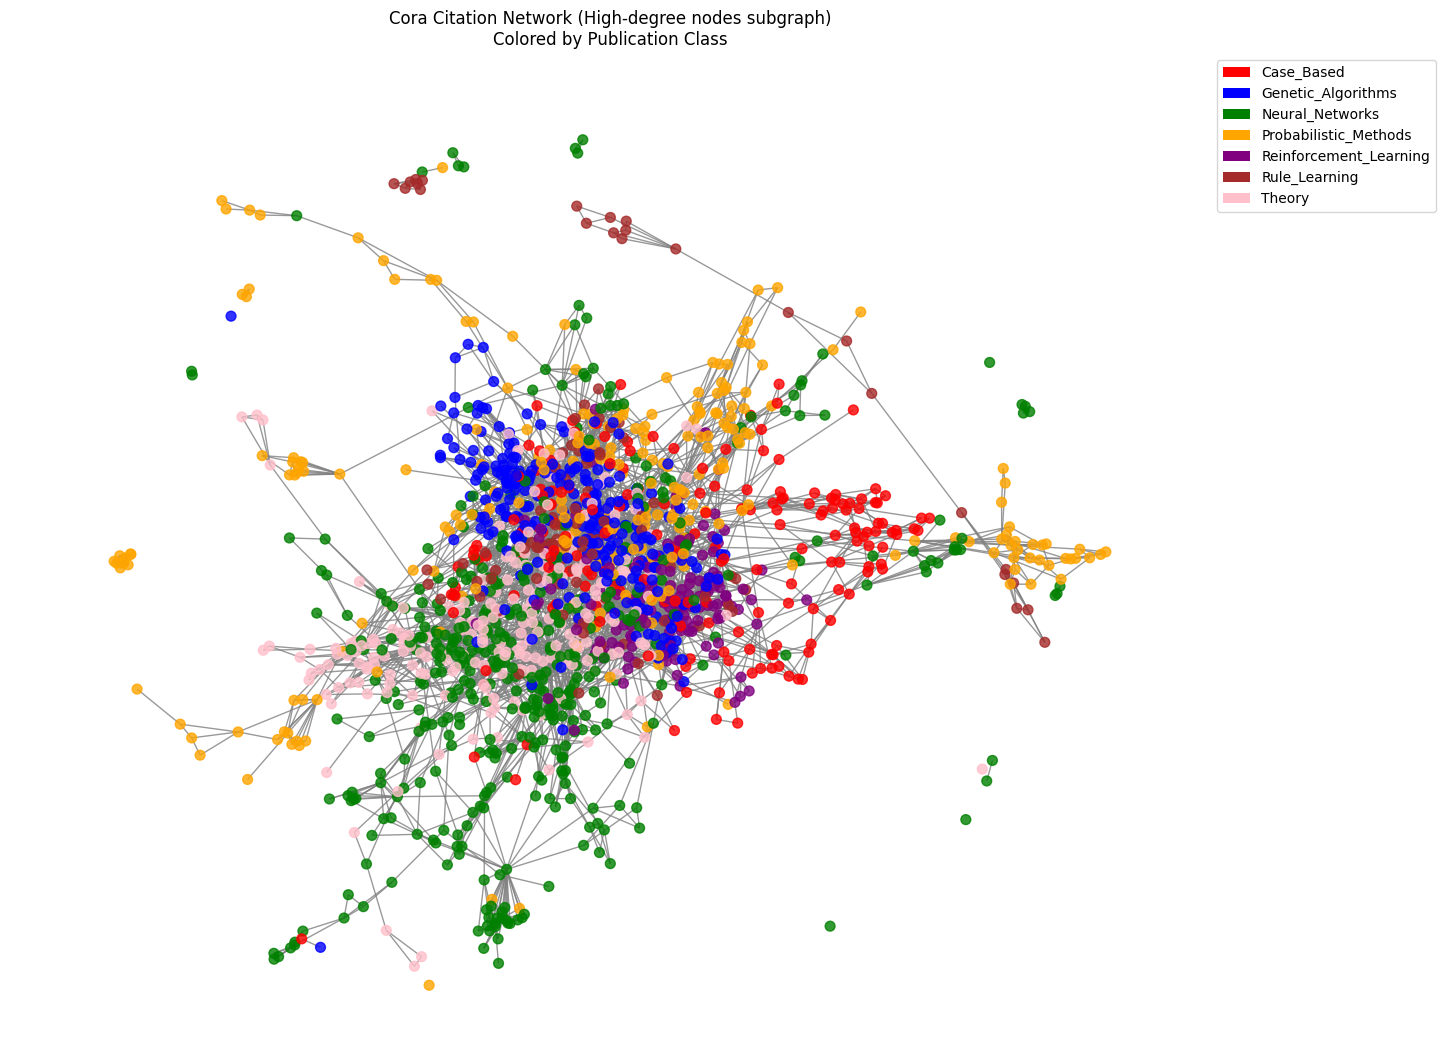

In [5]:
# Network visualization of a subset of the graph
import networkx as nx
from matplotlib.patches import Patch

# Class distribution
class_names = [
    "Case_Based",
    "Genetic_Algorithms",
    "Neural_Networks",
    "Probabilistic_Methods",
    "Reinforcement_Learning",
    "Rule_Learning",
    "Theory",
]

# Create a NetworkX graph from a subset of nodes (for visualization purposes)
# Using only nodes with high degree to keep visualization manageable
# threshold  of degree where node degree is in the top 10%
high_degree_threshold = np.percentile(degrees, 50)  # Top 10% by degree

high_degree_nodes = np.where(degrees >= high_degree_threshold)[0]

print(
    f"Visualizing subgraph with {len(high_degree_nodes)} high-degree nodes (degree >= {high_degree_threshold:.0f})"
)

# Create subgraph
G = nx.Graph()
G.add_nodes_from(high_degree_nodes)

# Add edges between high-degree nodes
for u, v in pos_edges:
    if u in high_degree_nodes and v in high_degree_nodes:
        G.add_edge(u, v)

print(f"Subgraph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Create node colors based on class labels
node_colors = [labels[node] for node in G.nodes()]
colors = ["red", "blue", "green", "orange", "purple", "brown", "pink"]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=1, iterations=50)
nx.draw(
    G,
    pos,
    node_color=[colors[c] for c in node_colors],
    node_size=50,
    edge_color="gray",
    alpha=0.8,
    with_labels=False,
)

# Create legend

legend_elements = [
    Patch(facecolor=colors[i], label=class_names[i]) for i in range(len(class_names))
]
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1, 1))
plt.title(
    "Cora Citation Network (High-degree nodes subgraph)\nColored by Publication Class"
)
plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
def get_alias_edge(G, src, curr, p, q):
    """Compute transition probabilities for neighbors of 'dst' based on Node2Vec bias.
    dst: current node
    src: previous node
    p: return back to previous node. Lower p means backtracking is more likely.
    q: in-out param: explore new nodes (ratio of bfs[breadth-first search] to dfs[depth-first search]).
        lower q means more exploration of distant nodes
    """
    unnormalized_probs = []
    for neighbor in G[curr]:
        if neighbor == src:
            weight = 1.0 / p
        elif G.has_edge(
            neighbor, src
        ):  # if neighbor is a neighbor of src (above ex: s1 is neighbor of t)
            weight = 1.0
        else:
            weight = 1.0 / q
        unnormalized_probs.append(weight)
    norm_const = sum(unnormalized_probs)
    normalized_probs = [w / norm_const for w in unnormalized_probs]
    return list(G[curr]), normalized_probs


def node2vec_walk(G, start, walk_length, p, q):
    """Generate a random walk starting from the given node."""
    walk = [start]
    while len(walk) < walk_length:
        cur = walk[-1]
        neighbors = list(G.neighbors(cur))
        if len(neighbors) == 0:
            break
        if len(walk) == 1:
            next_node = random.choice(neighbors)
        else:
            prev = walk[-2]
            candidates, probs = get_alias_edge(G, src=prev, curr=cur, p=p, q=q)
            next_node = random.choices(candidates, weights=probs, k=1)[0]
        walk.append(next_node)
    return walk


def gen_walk_pairs(walk, window_size):
    walk_pairs = []
    for i, target in enumerate(walk):
        start = max(0, i - window_size)
        end = min(len(walk), i + window_size + 1)
        ic(i, target, start, end)
        for j in range(start, end):
            if i != j:
                ic("pair", target, j, walk[j])
                if walk[j] != target:  # Avoid pairs of the same node
                    walk_pairs.append((target, walk[j]))

    return walk_pairs


def generate_random_walks(adj: np.numarray, walk_length=10, num_walks=5):
    G = nx.from_numpy_array(adj)
    walks = []
    for _ in range(num_walks):
        nodes = list(G.nodes())
        random.shuffle(nodes)
        for node in nodes:
            walk = node2vec_walk(G, node, walk_length, p=1, q=1)
            walks.append(walk)
    return walks


In [7]:
p = 1
q = 0.2
walk_length = 10
num_walks = 2
walks = generate_random_walks(
    adj=adj_bar.numpy(), walk_length=walk_length, num_walks=num_walks
)
ic(len(walks), walks[:2])

ic.disable()
pos_pairs = []
for walk in walks:
    pairs = gen_walk_pairs(walk, window_size=2)
    pos_pairs.extend(pairs)

num_positive_samples = len(pos_pairs)
ic(num_positive_samples)

ic| len(walks): 5416
    walks[:2]: [[1364, 1705, 459, 1705, 459, 267| len(walks): 5416
    walks[:2]: [[1364, 1705, 459, 1705, 459, 267, 459, 1705, 1469, 1003],
                [, 459, 1705, 1469, 1003],
                [262, 793, 1070, 163, 1274, 1303, 163,262, 793, 1070, 163, 1274, 1303, 163, 1530, 2089, 1603]] 1530, 2089, 1603]]



158302

In [8]:
# Negative samples (random non-walk pairs)
ic.enable()
pos_pair_set = set(tuple(p) for p in pos_pairs)
ic(len(pos_pair_set))

neg_pairs = []
num_negative_samples = 0
while num_negative_samples < num_positive_samples:
    u, v = np.random.randint(0, N, 2)
    if u != v and (u, v) not in pos_pair_set:
        neg_pairs.append([u, v])
        num_negative_samples += 1

ic(len(neg_pairs), neg_pairs[:5]);


ic| len(pos_pair_set): 35440| len(pos_pair_set): 35440

ic| len(neg_pairs): 158302
    neg_pairs[:5]: [[1084, 249], [2220, 500], [1218, 614], [2248, 1152],ic| len(neg_pairs): 158302
    neg_pairs[:5]: [[1084, 249], [2220, 500], [1218, 614], [2248, 1152], [1127, 1007]]
 [1127, 1007]]


## Model

In [ ]:
# GNN Layer (with separate W for neighbors and B for self)
class GNNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GNNLayer, self).__init__()
        self.W = nn.Parameter(torch.FloatTensor(in_dim, out_dim))
        self.B = nn.Parameter(torch.FloatTensor(in_dim, out_dim))
        nn.init.xavier_uniform_(self.W)
        nn.init.xavier_uniform_(self.B)

    def forward(self, h, adj_bar):
        # Neighbor aggregation: adj_bar @ h @ W (where adj_bar = D^{-1} A).
        # adj_bar stands for adjusted adjacency matrix.
        # torch.mm is optimized for 2d matrix operations: faster, less memory,..
        neigh_h = torch.mm(adj_bar, h)
        neigh_h = torch.mm(neigh_h, self.W)
        # Self transformation: h @ B
        self_h = torch.mm(h, self.B)
        # Add them
        return neigh_h + self_h


# GNN Encoder
class GNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GNNEncoder, self).__init__()
        self.layer1 = GNNLayer(
            input_dim, hidden_dim
        )  # Map features size to hidden size
        self.layer2 = GNNLayer(hidden_dim, hidden_dim)
        self.layer3 = GNNLayer(hidden_dim, embedding_dim)
        self.activation = nn.ReLU()

    def forward(self, x, adj_bar):
        h = self.layer1(x, adj_bar)
        h = self.activation(h)
        h = self.layer2(h, adj_bar)
        h = self.activation(h)
        h = self.layer3(h, adj_bar)  # No activation on last layer for embeddings
        return h


In [11]:
model = GNNEncoder(input_dim=features_nb, hidden_dim=32, embedding_dim=16).to(device)
z = model(x.to(device), adj_bar.to(device))
ic(
    z.shape
)  # Should be (N, 16), N being number of nodes. As expected, we have a 16-dim embedding for each node.

ic| z.shape: torch.Size([2708, 16])


torch.Size([2708, 16])

In [12]:
# Decoder: compute logit (dot product) as similarity measure. Like in node2vec or others previously seen.
def decode(z, edges):
    return torch.sum(z[edges[:, 0]] * z[edges[:, 1]], dim=1)


ic("There are ", pos_edges.shape[0], " edges in the graph. -> positive samples.")
ic(pos_edges.shape)
pos_edges_tensor = torch.LongTensor(pos_edges).to(device)
ic(decode(z, pos_edges_tensor).shape);  # Should be (num_pos,)

ic| "There are ": 'There are '
    pos_edges.shape[0]: 5429
    " edges in the graph. -> positive samples.": ' edges in the graph. -> positive samples.'
ic| pos_edges.shape: (5429, 2)
ic| decode(z, pos_edges_tensor).shape: torch.Size([5429])


In [13]:
# Training

# x, adj_bar, pos_edges, labels, N = load_cora()
# data has been loaded above
model = GNNEncoder(input_dim=features_nb, hidden_dim=32, embedding_dim=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Use randow walk
num_positive_pairs = len(pos_pairs)
num_negative_pairs = len(neg_pairs)
ic(num_positive_pairs, num_negative_pairs)
neg_pairs_tensor = torch.LongTensor(neg_pairs).to(device)
pos_pairs_tensor = torch.LongTensor(pos_pairs).to(device)

x = x.to(device)
adj_bar = adj_bar.to(device)  # (where adj_bar = D^{-1} A)
# labels = labels.to(device)

for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    z = model(x, adj_bar)

    # Positive logits
    # for positive edges, decode similarity should be high (1)
    pos_logits = decode(z, pos_pairs_tensor)

    # for negative edges, decode similarity should be low (0)
    neg_logits = decode(z, neg_pairs_tensor)

    # Labels: 1 for pos, 0 for neg
    pos_labels = torch.ones(num_positive_pairs).to(device=device)
    neg_labels = torch.zeros(num_negative_pairs).to(device=device)

    # Loss
    loss = binary_cross_entropy_with_logits(
        pos_logits, pos_labels
    ) + binary_cross_entropy_with_logits(neg_logits, neg_labels)

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# return model, x, adj_bar, labels
ic(model, x, adj_bar, labels);


ic| num_positive_pairs: 158302, num_negative_pairs: 158302


Epoch 0, Loss: 1.3875
Epoch 20, Loss: 0.9776
Epoch 40, Loss: 0.8911
Epoch 60, Loss: 0.8481
Epoch 80, Loss: 0.8190
Epoch 100, Loss: 0.7970
Epoch 120, Loss: 0.7808
Epoch 140, Loss: 0.7686
Epoch 160, Loss: 0.7584
Epoch 180, Loss: 0.7520
Epoch 200, Loss: 0.7418
Epoch 220, Loss: 0.7357
Epoch 240, Loss: 0.7300
Epoch 260, Loss: 0.7258
Epoch 280, Loss: 0.7189
Epoch 300, Loss: 0.7139
Epoch 320, Loss: 0.7119
Epoch 340, Loss: 0.7095
Epoch 360, Loss: 0.7037
Epoch 380, Loss: 0.7034
Epoch 400, Loss: 0.7008
Epoch 420, Loss: 0.6955
Epoch 440, Loss: 0.6958
Epoch 460, Loss: 0.7070
Epoch 480, Loss: 0.6900


ic| model: GNNEncoder(
             (layer1): GNNLayer()
             (layer2): GNNLayer()
             (layer3): GNNLayer()
             (activation): ReLU()
           )
    x: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.],
               ...,
               [0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0')
    adj_bar: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
                     [0., 0., 0.,  ..., 0., 0., 0.],
                     [0., 0., 0.,  ..., 0., 0., 0.],
                     ...,
                     [0., 0., 0.,  ..., 0., 0., 0.],
                     [0., 0., 0.,  ..., 0., 0., 0.],
                     [0., 0., 0.,  ..., 0., 0., 0.]], device='mps:0')
    labels: array([2, 5, 4, ..., 1, 0, 2])


In [14]:
# Inference: Generate embeddings
def inference(model, x, adj_bar):
    model.eval()
    with torch.no_grad():
        z = model(x, adj_bar)
    return z.cpu().numpy()


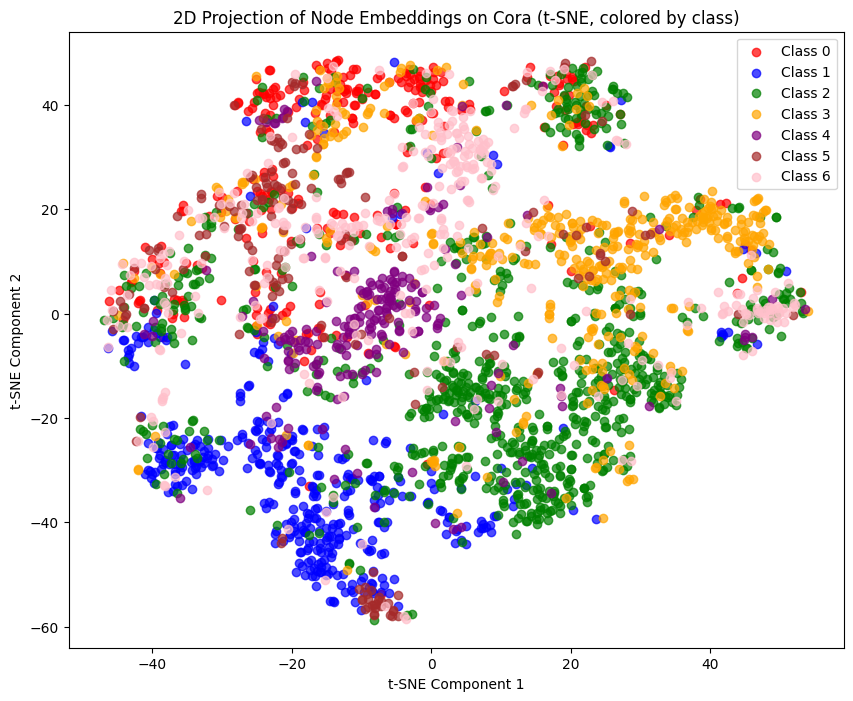

In [15]:
from sklearn.manifold import TSNE


def visualize_tsne_embeddings(z, labels):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    z_2d = tsne.fit_transform(z)

    colors = ["red", "blue", "green", "orange", "purple", "brown", "pink"]
    unique_labels = np.unique(labels)

    plt.figure(figsize=(10, 8))
    for i, lbl in enumerate(unique_labels):
        mask = labels == lbl
        plt.scatter(
            z_2d[mask, 0],
            z_2d[mask, 1],
            c=colors[i % len(colors)],
            label=f"Class {lbl}",
            alpha=0.7,
        )
    plt.legend()
    plt.title("2D Projection of Node Embeddings on Cora (t-SNE, colored by class)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()


z = inference(model, x, adj_bar)
visualize_tsne_embeddings(z, labels)

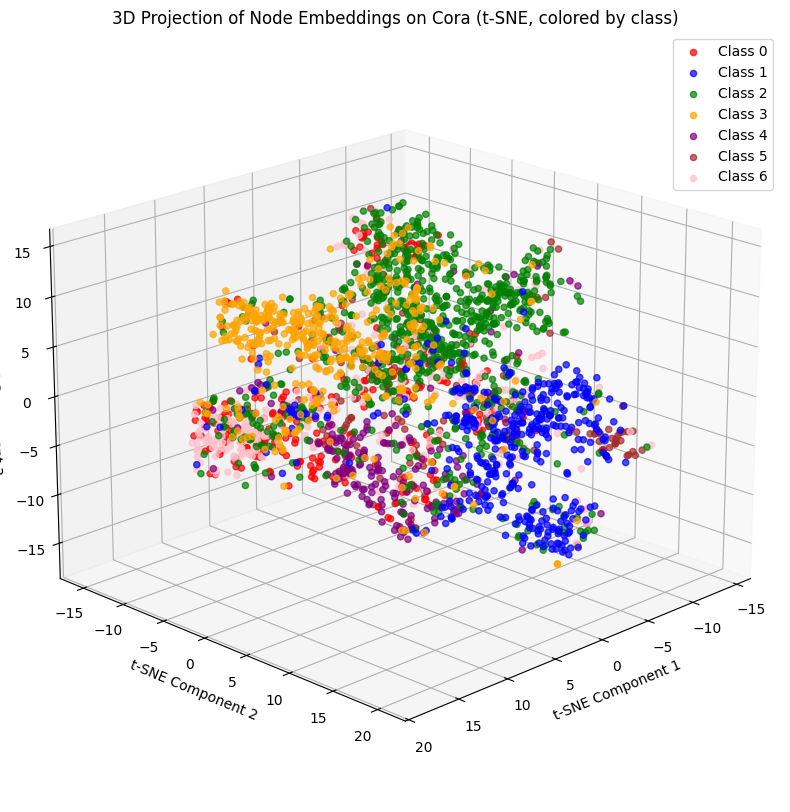

In [16]:
from mpl_toolkits.mplot3d import Axes3D


def visualize_tsne_embeddings_3d(z, labels):
    tsne = TSNE(n_components=3, random_state=42, perplexity=30, max_iter=1000)
    z_3d = tsne.fit_transform(z)

    colors = ["red", "blue", "green", "orange", "purple", "brown", "pink"]
    unique_labels = np.unique(labels)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection="3d")

    for i, lbl in enumerate(unique_labels):
        mask = labels == lbl
        ax.scatter(
            z_3d[mask, 0],
            z_3d[mask, 1],
            z_3d[mask, 2],
            c=colors[i % len(colors)],
            label=f"Class {lbl}",
            alpha=0.7,
            s=20,  # point size
        )

    ax.legend()
    ax.set_title("3D Projection of Node Embeddings on Cora (t-SNE, colored by class)")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.set_zlabel("t-SNE Component 3")

    # Enable rotation
    ax.view_init(elev=20, azim=45)
    plt.show()


# Generate 3D t-SNE visualization
visualize_tsne_embeddings_3d(z, labels)

In [18]:
import torch
from torch.utils.tensorboard import SummaryWriter
import os


def visualize_embeddings_tensorboard(z, labels, class_names, log_dir="runs/embeddings"):
    """
    Visualize embeddings in TensorBoard with interactive 3D projection
    """
    # Create log directory
    os.makedirs(log_dir, exist_ok=True)

    # Initialize TensorBoard writer
    writer = SummaryWriter(log_dir)

    # Convert to torch tensor if needed
    if isinstance(z, np.ndarray):
        embeddings = torch.FloatTensor(z)
    else:
        embeddings = z

    # Create metadata (class labels)
    metadata = [class_names[label] for label in labels]

    # Add embeddings to TensorBoard
    writer.add_embedding(embeddings, metadata=metadata, tag="Node_Embeddings")

    writer.close()
    print(f"Embeddings saved to TensorBoard. Run the following command to view:")
    print(f"tensorboard --logdir=nbks/{log_dir}")
    print("Then open your browser to http://localhost:6006")
    print("Navigate to the 'Projector' tab to see the interactive 3D visualization")


# Generate TensorBoard visualization
class_names = [
    "Case_Based",
    "Genetic_Algorithms",
    "Neural_Networks",
    "Probabilistic_Methods",
    "Reinforcement_Learning",
    "Rule_Learning",
    "Theory",
]

visualize_embeddings_tensorboard(z, labels, class_names)

# uv run tensorboard --logdir nbks/runs/embeddings

Embeddings saved to TensorBoard. Run the following command to view:
tensorboard --logdir=nbks/runs/embeddings
Then open your browser to http://localhost:6006
Navigate to the 'Projector' tab to see the interactive 3D visualization


# use classification instead of similarity as target

In [19]:
class GNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, num_classes):
        super(GNNClassifier, self).__init__()
        self.layer1 = GNNLayer(input_dim, hidden_dim)
        self.layer2 = GNNLayer(hidden_dim, hidden_dim)
        self.layer3 = GNNLayer(hidden_dim, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)
        self.activation = nn.ReLU()

    def forward(self, x, adj_bar):
        h = self.layer1(x, adj_bar)
        h = self.activation(h)
        h = self.layer2(h, adj_bar)
        h = self.activation(h)
        h = self.layer3(h, adj_bar)  # Embeddings
        logits = self.classifier(h)  # Classification logits
        return h, logits  # Return embed

7

In [30]:
nb_classes = len(set(labels.tolist()))
model = GNNClassifier(
    input_dim=features_nb, hidden_dim=32, embedding_dim=16, num_classes=nb_classes
).to(device)
h, logits = model(x.to(device), adj_bar.to(device))
ic(h.shape, logits.shape)  # h: (N, 16), logits: (N, 7)

ic| h.shape: torch.Size([2708, 16])
    logits.shape: torch.Size([2708, 7])


(torch.Size([2708, 16]), torch.Size([2708, 7]))